# 使用原始文本学习词嵌入空间
获取词嵌入有两种方法：
1. 在完成主任务（如本例中的评论分类）的同时学习词嵌入。这种方式一开始使用随机词向量，通过完成任务的过程对词向量进行学习，类似权重学习，通过梯度下降完成。
2. 在其他机器学习任务上得到词嵌入，将外面项目学到的词嵌入加载到本模型中直接利用，即**预训练词嵌入**<br>

本例使用第一种方法。由于自然语言具有特定的情境，法律类别的文本与评论类别的文本就有很大的差异，产生的词嵌入空间也可能差距很大，因为语义在不同的空间里可能会非常不同。如果语料充足，比较合理的做法还是重新学校新的嵌入空间。



In [1]:
import keras
keras.__version__

Using TensorFlow backend.
C:\Anaconda\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:529: Fu

'2.3.1'

# 电影评论分类：二分类问题
判断评论是正面还是负面

# IMDB 数据集
IMDB 数据集，它包含来自互联网电影数据库（IMDB）的 50 000 条严重两极分化的评论。数据集被分为用于训练的 25 000 条评论与用于测试的 25 000 条评论，训练集和测试集都包含 50% 的正面评论和 50% 的负面评论。

与 MNIST 数据集一样，IMDB 数据集也内置于 Keras 库。它已经过**预处理**：评论（单词序列） **已经被转换为整数序列**，其中每个整数代表字典中的某个单词。 下列代码将会加载 IMDB 数据集（第一次运行时会下载大约 80MB 的数据，可以不翻墙，反复试几次）。

参数 num_words=10000 的意思是仅保留训练数据中前 10 000 个最常出现的单词。**低频单词将被舍弃**。这样得到的向量数据不会太大，便于处理。

train_data 和 test_data 这两个变量都是评论组成的列表，每条评论又是单词索引组成 的列表（表示一系列单词）。train_labels 和 test_labels 都是 0 和 1 组成的列表，其中 0 代表负面（negative），1 代表正面（positive）。

imdb.npz 数据集被单独下载存放在：C:\Users\xxxxxx\.keras\datasets

In [2]:
from keras.datasets import imdb

(train_data, y_train), (test_data, y_test) = imdb.load_data(num_words=10000)

In [3]:
test_data.shape

(25000,)

In [4]:
print(y_train[0])
print(train_data[0])

1
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [5]:
#对于训练数据，求它们的最大值，由于单词不超过1000个，因此单词编号（索引不会超过1000）
max([max(sequence) for sequence in train_data])

9999

由于数据集给出的每个单词都是一个索引。我们可以将这个索引号对应的单词找出来形成一个单词和索引的字典。reverse_word_index，这个就是输入索引（key），得到单词（value）

In [6]:
# 如果好奇的话，你可以用下列代码将索引解码为单词
# word_index 是一个将单词映射为整数索引的字典
word_index = imdb.get_word_index()
# 键值颠倒，将整数索引映射为单词
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
#将评论解码。注意，索引减去了 3，
# 因为 0、1、2 是为“padding”（填充）、“start of sequence”（序列开始）、“unknown”（未知词）分别保留的索引
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [7]:
decoded_review 

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

In [8]:
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[1]])
decoded_review

"? big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal ? the hair is big lots of boobs ? men wear those cut ? shirts that show off their ? sickening that men actually wore them and the music is just ? trash that plays over and over again in almost every scene there is trashy music boobs and ? taking away bodies and the gym still doesn't close for ? all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then"

In [9]:
maxlen = 50

In [10]:
from keras import preprocessing

#将整数列表转为samples，maxlen（20）的二维张量
x_train = preprocessing.sequence.pad_sequences(train_data, maxlen = maxlen)
x_test =  preprocessing.sequence.pad_sequences(test_data, maxlen = maxlen)

In [11]:
print("x_train:", x_train.shape)
print("x_test:", x_test.shape)

x_train: (25000, 50)
x_test: (25000, 50)


# 创建网络
<img src="images/1.JPG" style="width:1000px;height:350px;" ><br>
不太明白的地方就是，吴恩达的教程中，输入的是one-hot编码，但是这里好像没有做这个预处理（是在嵌入层里面做的？）

In [12]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(10000, 16, input_length = maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


<img src="images/2.JPG" style="width:1200px;height:400px;" ><br>

In [13]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 16)            160000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 801       
Total params: 160,801
Trainable params: 160,801
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(x_train,y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 50us/step - loss: 0.6164 - accuracy: 0.6843 - val_loss: 0.4916 - val_accuracy: 0.7748
Epoch 2/10
20000/20000 [==============================] - 1s 50us/step - loss: 0.4063 - accuracy: 0.8241 - val_loss: 0.4137 - val_accuracy: 0.8052
Epoch 3/10
20000/20000 [==============================] - 1s 52us/step - loss: 0.3353 - accuracy: 0.8558 - val_loss: 0.4000 - val_accuracy: 0.8120
Epoch 4/10
20000/20000 [==============================] - 1s 46us/step - loss: 0.2952 - accuracy: 0.8748 - val_loss: 0.4001 - val_accuracy: 0.8164
Epoch 5/10
20000/20000 [==============================] - 1s 54us/step - loss: 0.2626 - accuracy: 0.8924 - val_loss: 0.4041 - val_accuracy: 0.8166
Epoch 6/10
20000/20000 [==============================] - 1s 50us/step - loss: 0.2318 - accuracy: 0.9078 - val_loss: 0.4120 - val_accuracy: 0.8126
Epoch 7/10
20000/2000

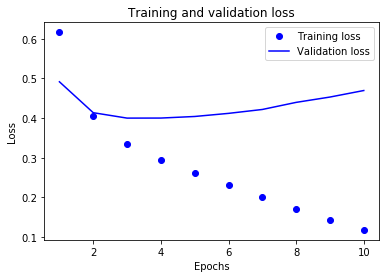

In [15]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"（'bo' 表示蓝色圆点）
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"（'b' 表示蓝色实线）
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

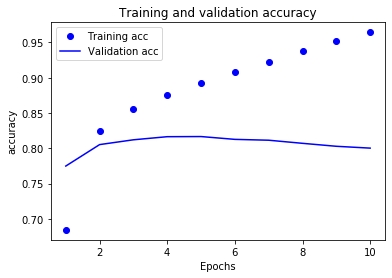

In [16]:
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

In [17]:
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
import matplotlib.pyplot as plt

def trainEmbed(maxlen, vectorlen):
    #将整数列表转为samples，maxlen（20）的二维张量
    x_train = preprocessing.sequence.pad_sequences(train_data, maxlen = maxlen)
    x_test =  preprocessing.sequence.pad_sequences(test_data, maxlen = maxlen)
    model = Sequential()
    model.add(Embedding(10000, 8, input_length = maxlen))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    history = model.fit(x_train,y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)
    acc_values = history.history['accuracy']
    val_acc_values = history.history['val_accuracy']
    return val_acc_values


In [18]:
results = []
names = []
maxlenLst=[20,50,100,200,300]
for i in maxlenLst:
    names.append(str(i))
    ret = trainEmbed(i, 8)
    results.append(ret)
    

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 40us/step - loss: 0.6595 - accuracy: 0.6420 - val_loss: 0.6003 - val_accuracy: 0.7094
Epoch 2/10
20000/20000 [==============================] - 1s 46us/step - loss: 0.5297 - accuracy: 0.7567 - val_loss: 0.5204 - val_accuracy: 0.7346
Epoch 3/10
20000/20000 [==============================] - 1s 39us/step - loss: 0.4583 - accuracy: 0.7886 - val_loss: 0.4976 - val_accuracy: 0.7452
Epoch 4/10
20000/20000 [==============================] - 1s 39us/step - loss: 0.4194 - accuracy: 0.8120 - val_loss: 0.4916 - val_accuracy: 0.7564
Epoch 5/10
20000/20000 [==============================] - 1s 44us/step - loss: 0.3913 - accuracy: 0.8245 - val_loss: 0.4919 - val_accuracy: 0.7582
Epoch 6/10
20000/20000 [==============================] - 1s 38us/step - loss: 0.3677 - accuracy: 0.8392 - val_loss: 0.4967 - val_accuracy: 0.7592
Epoch 7/10
20000/20000 [==============================] - 1s 46us/ste

#  截取的语句长度对预测准确度的影响
显然语句越长，准确度越高，但是到了一定的长度增长不明显

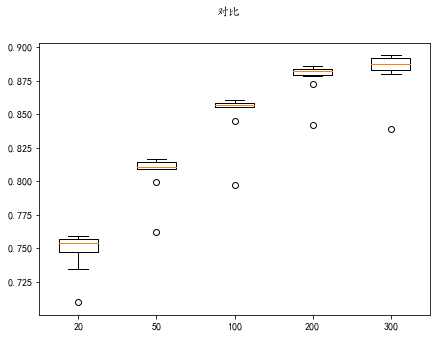

In [19]:
plt.rcParams['font.sans-serif'] = ['KaiTi']#作图的中文
plt.rcParams['font.serif'] = ['KaiTi']#作图的中文
fig = plt.figure(figsize=(7,5))
fig.suptitle('对比')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [20]:
results = []
names = []
vecLenLst=[8,16,32,64,128]
for i in vecLenLst:
    names.append(str(i))
    ret = trainEmbed(200,i)
    results.append(ret)
    

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 91us/step - loss: 0.5679 - accuracy: 0.7214 - val_loss: 0.3786 - val_accuracy: 0.8518
Epoch 2/10
20000/20000 [==============================] - 2s 87us/step - loss: 0.2999 - accuracy: 0.8798 - val_loss: 0.3031 - val_accuracy: 0.8718
Epoch 3/10
20000/20000 [==============================] - 2s 81us/step - loss: 0.2328 - accuracy: 0.9084 - val_loss: 0.2801 - val_accuracy: 0.8872
Epoch 4/10
20000/20000 [==============================] - 2s 85us/step - loss: 0.1996 - accuracy: 0.9224 - val_loss: 0.2789 - val_accuracy: 0.8908
Epoch 5/10
20000/20000 [==============================] - 2s 80us/step - loss: 0.1777 - accuracy: 0.9324 - val_loss: 0.2831 - val_accuracy: 0.8898
Epoch 6/10
20000/20000 [==============================] - 2s 88us/step - loss: 0.1602 - accuracy: 0.9392 - val_loss: 0.3013 - val_accuracy: 0.8840
Epoch 7/10
20000/20000 [==============================] - 2s 86us/ste

In [21]:
names = ['0']+names

# 不同词向量对分类的影响
总体影响并不是很大，从图中可以看出32长度的词向量性能最好。

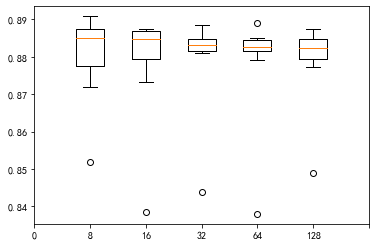

In [22]:
fig.suptitle('不同词向量长度对比')
plt.boxplot(results)
plt.xticks(range(len(names)+1),names)
plt.show()